In [2]:
# Project imports #
import pandas as pd
import numpy as np
import psycopg2 as pg2
import matplotlib.pyplot as plt
import json
import csv
import re
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from arch.unitroot import engle_granger
from datetime import datetime
import calendar
from calendar import monthrange
# Matplotlib settings #
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

# Extension of Project - Extension 3
#### Objective: To see how local and occupational labor demand has changed based on the jobads available on platsbanken between 2006-2020

#### Project outline
- Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
- Step 2: Inserting data into a PostgreSQL database and setting up a query
- Step 3: Visualization and discussion of results
- Step 4: Time series analysis
- Concluding remarks

### Step 1: Converting JSON files to CSV and extracting relevant data (+data cleaning)
#### All job ads data used in this project is from [JobTechDev](https://jobtechdev.se/en/docs/apis/historical/), an initiative by the Swedish public employment service.

- Variables to be extracted for this project are the following:
    - **headline**: The ad headline.
    - **number_of_vacancies**: The number of advertised jobs for a given ad, a majority only advertise 1 job (5M out of 6.4M ads).
    - **publication_date**: Date the ad was published on Platsbanken, the job ad platform.
    - **application_deadline**: The last date to apply for the job.
    - **last_publication_date**: The last date the ad was public, used as substitutet for application_deadline for 2017 where application_deadline is missing.
    - **municipality_code**: The unique code associated with each municipality in Sweden
    - **occupation_group**: Occupation group on the 4th level of SSYK

In [3]:
total_valid = 0; total_errors = 0
for file in range(2006,2021):
    with open(f'/Users/Kevin/Desktop/project_dta/new_pb_2006_2020/{file}.json') as f:
        ads = json.load(f)
        file_ads = []
        error_rows = 0
        
    # For 2017 application_deadline is null, last_publication_date used as a proxy, vars 99.8% equivalent #
    for ad in ads:
        # Removal of special characters using regex, events of \n causes errors in csv file #
        head_line = re.sub('[!,*)@#%(&$_?.^\\\\\n/]', '', str(ad['headline']))
        if file != 2017:
            try: 
        # Slicing of date variables is to ensure only dates of the format 'yyyy-mm-dd' are included, no time data needed #
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10], int(ad['workplace_address']['municipality_code']), int(ad['occupation_group']['legacy_ams_taxonomy_id'])]
            except:
                error_rows += 1
                continue
        else:
            try:
                ad_select = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10], int(ad['workplace_address']['municipality_code']), int(ad['occupation_group']['legacy_ams_taxonomy_id'])]
            except:
                error_rows += 1
                continue
                
        # Jobs ads with no vacancies (=0) or missing values (None) in dates or vacancies are removed using all() #
        if all(ad_select[1:]):
            file_ads.append(ad_select)
        else:
            error_rows += 1
            continue
    # We write the extracted data to a csv file for easy insertion into PostgreSQL #             
    with open(f'/Users/Kevin/Desktop/project_dta/extension_3/{file}_municode_occupation.csv', mode='w', newline="") as file_writer:
        write = csv.writer(file_writer)
        for row in file_ads:
            write.writerow(row)
    print(f'valid ads for {file}: ' + str(len(file_ads)), ' | ', f'erroneous ads for {file}: ' + str(error_rows))
    total_valid += len(file_ads); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), '   |  ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2006: 21  |  erroneous ads for 2006: 245206
valid ads for 2007: 33591  |  erroneous ads for 2007: 250514
valid ads for 2008: 177998  |  erroneous ads for 2008: 87225
valid ads for 2009: 137174  |  erroneous ads for 2009: 58950
valid ads for 2010: 214008  |  erroneous ads for 2010: 75246
valid ads for 2011: 296940  |  erroneous ads for 2011: 67748
valid ads for 2012: 309110  |  erroneous ads for 2012: 70248
valid ads for 2013: 316092  |  erroneous ads for 2013: 73961
valid ads for 2014: 388634  |  erroneous ads for 2014: 63351
valid ads for 2015: 574481  |  erroneous ads for 2015: 39032
valid ads for 2016: 690854  |  erroneous ads for 2016: 27192
valid ads for 2017: 692449  |  erroneous ads for 2017: 22842
valid ads for 2018: 658276  |  erroneous ads for 2018: 24693
valid ads for 2019: 514061  |  erroneous ads for 2019: 126196
valid ads for 2020: 449788  |  erroneous ads for 2020: 40925


total valid ads: 5453477    |   total erroneous ads: 1273329


- More rows are filtered out now that restrictions are harder. Now, if the municipality code is NULL, row is discarded

### Step 2: Inserting data into a postgreSQL database and setting up relevant query
 - For efficient analysis and storage of the dataset we import the data into PostgreSQL.

In [18]:
# DB created in pgAdmin4 GUI, login and connect cursor #
conn = pg2.connect(database='job_ads', user='postgres', password='*************')
cur = conn.cursor()

In [14]:
# Table creation # 
# If data cleaning method in previous step missed any invalid ads, NOT NULL ascertains that no invalid ads are included #
cur.execute("""
CREATE TABLE historic_ads_extension_3 (
    ad_id SERIAL PRIMARY KEY,
    headline VARCHAR,
    number_of_vacancies INTEGER NOT NULL,
    publication_date DATE NOT NULL,
    application_deadline DATE NOT NULL,
    municipality_code INTEGER NOT NULL,
    occupation_group INTEGER NOT NULL)
    ;""")
conn.commit()

In [15]:
# Importing csv files into PostgreSQL #
for file in range(2008, 2021):
    with open(f'/Users/Kevin/Desktop/project_dta/extension_3/{file}_municode_occupation.csv', 'r') as csv_file:
        cur.copy_from(csv_file, 'historic_ads_extension_3', sep=',', columns=('headline', 'number_of_vacancies', 'publication_date', 'application_deadline', 'municipality_code', 'occupation_group'))
    conn.commit()
# 5419865 ads in table

* The tables we join on have been created in extension 1 and 2. Preperation of the join data has been done in the masters_project/misc/extra_code.

In [16]:
# Full inner join #
cur.execute("""
    CREATE TABLE historic_ads_extension_3_1 AS 
    (SELECT ad_id, headline, number_of_vacancies, publication_date, application_deadline, historic_ads_extension_3.municipality_code, municipality_codes.municipality_name, municipality_codes.municipality_group_code, municipality_codes.municipality_group_name, municipality_codes.county_code, municipality_codes.county_name, historic_ads_extension_3.occupation_group
    FROM historic_ads_extension_3
    INNER JOIN municipality_codes
    ON historic_ads_extension_3.municipality_code = municipality_codes.municipality_code);
    ;""")
conn.commit()

In [19]:
# Full inner join #
cur.execute("""
    CREATE TABLE historic_ads_extension_3_final AS 
    (SELECT historic_ads_extension_3_1.ad_id, historic_ads_extension_3_1.headline, historic_ads_extension_3_1.number_of_vacancies, historic_ads_extension_3_1.publication_date, historic_ads_extension_3_1.application_deadline, historic_ads_extension_3_1.municipality_code, historic_ads_extension_3_1.municipality_name, historic_ads_extension_3_1.municipality_group_code, historic_ads_extension_3_1.municipality_group_name, historic_ads_extension_3_1.county_code, historic_ads_extension_3_1.county_name, historic_ads_extension_3_1.occupation_group, ssyk.ssyk_code_1, ssyk.ssyk_desc_1, ssyk.ssyk_code_2, ssyk.ssyk_desc_2, ssyk.ssyk_code_4, ssyk.ssyk_desc_4
    FROM historic_ads_extension_3_1
    INNER JOIN ssyk
    ON historic_ads_extension_3_1.occupation_group = ssyk.ssyk_code_4);
    ;""")
conn.commit()
# Ads in table 5436643

In [20]:
vacancies_per_day = []
for year in range(2008, 2021):
    for month in range(1,13): 
        # cal.monthrange correctly sets the last day for each month #
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            cur.execute(f"""
SELECT SUM(number_of_vacancies) FROM historic_ads_extension_3_final WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline;
""")
            ads_day = [f'{year}-{month}-{day}', cur.fetchone()[0]]
            vacancies_per_day.append(ads_day)
# We save the results to a csv file #
with open(f'/Users/Kevin/Desktop/project_dta/extension_3/results.csv', mode='w', newline="") as file_writer:
    write = csv.writer(file_writer)
    for row in vacancies_per_day:
        write.writerow(row)

### Step 3: Visualization and discussion of results
* In this extension 3, we first want to evaluate if the main analysis and the data left in extension 3 are comparable. Since alot more restrictions are placed on this data, filtering out job ads that do not have municipality code or occupational group code, alot less ads are available. But, if they are still comparable, we might consider using only the data that passes the harder restrictions of extension 3, this to use the same data for all analysis so that any difference in data does not affect our analysis.

In [37]:
# Importing results and comparison csv files and adding appropriate datetime indexing #
results_main = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/results.csv', names=['date', 'ad_vacancies_main'])
results_main = results_main.set_index(pd.to_datetime(results_main['date'])).drop('date', axis=1)
results_extension3 = pd.read_csv('/Users/Kevin/Desktop/project_dta/extension_3/results.csv', names=['date', 'ad_vacancies_extension3'])
results_extension3 = results_extension3.set_index(pd.to_datetime(results_extension3['date'])).drop('date', axis=1)
comparison = pd.read_csv('/Users/Kevin/Desktop/project_dta/csv_pd2006_2020/lediga_jobb.csv').drop('quarter', axis=1)
comparison = comparison.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q'))

In [28]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2006','2022', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2006, 2022)

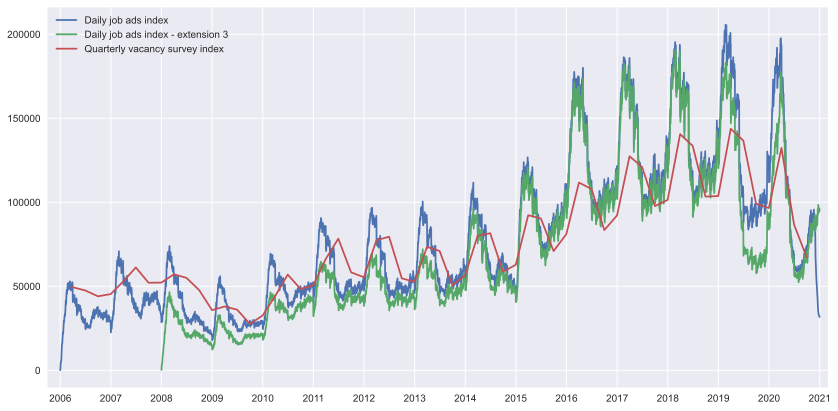

In [39]:
fig = plt.figure(figsize=(14,7))

plt.plot(results_main.index, results_main, label='Daily job ads index')
plt.plot(results_extension3.index, results_extension3, label='Daily job ads index - extension 3')
plt.plot(comparison.index, comparison, label='Quarterly vacancy survey index')

plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
plt.legend()

plt.savefig('/Users/Kevin/Desktop/project_dta/figure_results/results.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

### Discussion
- In the above figure we find that vacancies are somewhat affected by the decrease in total number of ads. Especially earlier years are affected by the lower number of ads.

### Concluding remarks
#### Thank you for examining my project! Pleas contact me if you have any feedback on possible improvement or other comments on the project.

Contact: [kevin.dee.boman@gmail.com](kevin.dee.boman@gmail.com)

#### Future project plans:

   - In a future project, a current labor demand index will be constructed using JobTechDevs API service in combination with ads scraped from supplementary sources that systematically are not posted on platsbanken (The public employment service job ads platform).
   - The index may also be disaggregated by county/city and occupational group using [SSYK classification](https://www.scb.se/dokumentation/klassifikationer-och-standarder/standard-for-svensk-yrkesklassificering-ssyk/) (Swedens official classification system for occupational groups, only available in Swedish). This would extend the use of the index as regional labor demand and labor demand among different occupational groups could be estimated.